# Two-parameter family of ODE solutions aka Process

$\min_\theta \mathop{\mathbb{E}}_{(I,J) \sim T, t \sim U[0,1]} ||J(\phi_\theta(I,J,0,t))-I(\phi_\theta(I,J,0,t-1))|| + \lambda \{|| \phi_\theta(I,J,t,t-1) \circ \phi_\theta(I,J,0,t) - \phi_\theta(I,J,0,t-1)|| + ||\phi_\theta(I,J,t-1,t) \circ \phi_\theta(I,J,0,t-1) - \phi_\theta(I,J,0,t)||\}$,

where $I$ and $J$ are images being registered and they are sampled from a training set $T$. $\phi_\theta(I,J,t1,t2) = (x,y) + (t2-t1)f_\theta(I,J,t1,t2)$ denotes a deformed grid/diffeomorphism, where $f_\theta$ is a neural network model, such as a Unet, with tunable parameters $\theta$. $I(\phi_\theta(I,J,0,t-1))$ and $J(\phi_\theta(I,J,0,t))$ denote warping of images $I$ and $J$ by the deformed grids $\phi_\theta(I,J,0,t-1)$ and $\phi_\theta(I,J,0,t)$, respectively. The symbol $\circ$ implies composition between two functions. Use interpolation to realize composition. $\lambda$ is the weight hyperparameter. $U$ denotes uniform distribution.

## Follow instructions to complete tasks
### Do not edit the following cell including new imports

In [1]:
# Do not edit this cell including any new imports

import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from skimage.color import rgb2gray
import torch.optim as optim
from skimage import io
from skimage.filters import gaussian
from skimage.transform import pyramid_gaussian
from torchvision.transforms.functional import gaussian_blur, resize, pad
from torch.nn.functional import interpolate
from skimage.transform import resize
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import cv2

from homography import dv_loss

random_seed = 1
torch.backends.cudnn.enabled = True
torch.manual_seed(random_seed)

# Checking GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### You can only edit folder paths to read images - do not edit anything else

32 32


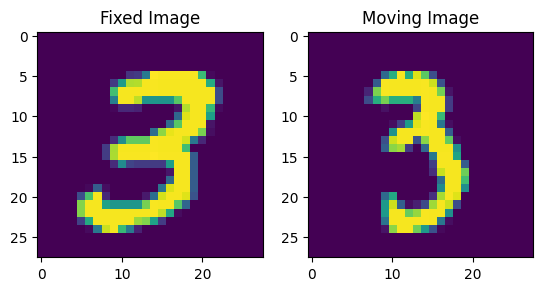

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

I = io.imread("7.png").astype(np.float32)/255.0
J = io.imread("74.png").astype(np.float32)/255.0

I_ = torch.tensor(gaussian(I,1.0).astype(np.float32)).unsqueeze(0).unsqueeze(0).to(device)
J_ = torch.tensor(gaussian(J,1.0).astype(np.float32)).unsqueeze(0).unsqueeze(0).to(device)

I_ = pad(I_, 2)
J_ = pad(J_, 2)

h_ = I_.shape[2]
w_ = I_.shape[3]

y_, x_ = np.meshgrid(np.arange(0,h_), np.arange(0,w_),indexing='ij')
y_, x_ = 2.0*y_/(h_-1) - 1.0, 2.0*x_/(w_-1) - 1.0

xy_ = torch.tensor(np.stack([x_,y_],2),dtype=torch.float32).unsqueeze(0).to(device)

print(h_, w_)
%matplotlib inline
fig=plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(I)
plt.title("Fixed Image")
fig.add_subplot(1,2,2)
plt.imshow(J)
plt.title("Moving Image")
plt.show()

### You have full control to edit the following cell to define your own time-embedded U-net / other architecture

#### The architecture given below is from the one parameter solution notebook

In [3]:
class Block(nn.Module): 
    def __init__(self, step_size, hidden=16): 
        super().__init__() 
        self.conv1a = nn.Conv2d(in_channels=2, out_channels=hidden, kernel_size=3, padding="same")
        self.conv1b = nn.Conv2d(in_channels=hidden, out_channels=2, kernel_size=3, padding="same")
        
        # self.conv2a = nn.Conv2d(in_channels=2, out_channels=hidden, kernel_size=1, padding="same")
        # self.conv2b = nn.Conv2d(in_channels=hidden, out_channels=2, kernel_size=1, padding="same")
        self.step_size = step_size
    def forward(self, x):    
        ha = F.elu(self.conv1a(x)) 
        va = self.conv1b(ha)

        # hb = F.elu(self.conv2a(x)) 
        # vb = self.conv2b(hb)

        v = va #+ vb

        return self.step_size * v + x, v 
    
class ResNet(nn.Module): 
    def __init__(self, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([Block(1/num_layers) for _ in range(num_layers)]) 
        self.num_layers = num_layers
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=1), 
            nn.SiLU(), 
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1)
        )
    def encode(self, I, J): 
        Ie = self.encoder(I)
        Je = self.encoder(J)
        return Ie, Je
    
    def forward(self, J, xy): 
        vs = []
        xys = []
        for l in self.layers: 
            xy, v = l(xy.permute(0, 3, 1, 2))
            xy = xy.permute(0, 2, 3, 1)
            xys.append(xy)
            vs.append(v)
        vs = torch.stack(vs, dim=0)
        J = F.grid_sample(J, xy, mode="bilinear", padding_mode="reflection", align_corners=False)
        return J, xy, {"vs": vs, "xys": xys}
    def loss(self, I, J, xy): 
        Jw, xyL, past = self(J, xy) 
        image_loss = dv_loss(Jw, I, encode_function=self.encode) 

        vs = past["vs"]
        xys = past["xys"]

        l, n, c, h, w = vs.shape 
        vs = vs.reshape(l, c, h, w) 
        laplacian = torch.tensor([[0, -1, 0], 
                                  [-1, 4, -1], 
                                  [0, -1, 0]], dtype=torch.float32, device=device)[None, None, ...]
        laplacian = torch.cat([laplacian, laplacian], dim=0)
        Lvs = F.conv2d(vs, laplacian, stride=1, padding=1, groups=2)
        


        flow_loss = (Lvs.norm(dim=1)**2).sum(dim=0).mean()/self.num_layers # [L, C, H, W]

        for intermed in xys: 
            image_loss += dv_loss(F.grid_sample(J, intermed, "bilinear", "reflection", False), I, encode_function=self.encode) / self.num_layers

        return image_loss, flow_loss

        

### In the following cell edit only the dotted lines to define phiI, phiJ, phiI_ and phiJ_. Do not edit any other lines.

### In the following cell you are allowed to change learning_rate, lam - nothing else. Do not change the number of iterations/epochs.

In [4]:
learning_rate = 3e-2
network = ResNet(num_layers=10).to(device)
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
optimizer1 = optim.Adam(network.parameters(), lr=0.01)

torch.cuda.empty_cache()

# identity loss
t0 = torch.zeros(1).to(device)
for epoch in range(500):
    optimizer1.zero_grad()
    t = torch.rand(1).to(device)
    J, xy, vs = network(J_,xy_)
    loss = torch.mean((xy-xy_)**2)
    loss.backward()
    optimizer1.step()
    if epoch%100==0:
        print("Epoch:",epoch,"Id loss:","{:.10f}".format(loss.item()))

        # print("I_:", I_.shape)
        # print("J_:", J_.shape)
        # print("xy:", xy.shape)

print("Epoch:",epoch,"Id loss:","{:.10f}".format(loss.item())
         )
print("")
# coarse to fine multi resolution optimization
L = 8
lam=2e1
nEpoch = 200

for epoch in range(nEpoch):
    res = np.sort((0.95-0.05)*np.linspace(0, 1, L-1)+0.05)
    res = np.concatenate((res,[0.05]))
    for level in range(L):
        optimizer.zero_grad()

        # print("I_:", I_.shape)
        # print("J_:", J_.shape)
        # print("xy:", xy.shape) 

        loss,ss_loss = network.loss(I_,J_,xy_)
        total_loss = loss+lam*ss_loss
        total_loss.backward()
        optimizer.step()
        if epoch%10==0:
            print("Epoch:",epoch,"Resolution:",L-1-level,"Total loss:","{:.6f}".format(total_loss.item()),
                             "Image loss:","{:.6f}".format(loss.item()),
                             "Constraint loss:","{:.10f}".format(ss_loss.item()),
             )
    if epoch%10==0:
        print("")
    scheduler.step()

for level in range(L):
    # print("I_:", I_.shape)
    # print("J_:", J_.shape)
    # print("xy:", xy.shape)
    # print("res:", res[level])
    loss,ss_loss = network.loss(I_,J_,xy_,)
    total_loss = loss+lam*ss_loss
    print("Resolution:",L-1-level,"Epoch:",nEpoch,"Total loss:","{:.6f}".format(total_loss.item()),
                         "image loss:","{:.6f}".format(loss.item()),
                         "Constraint loss:","{:.10f}".format(ss_loss.item()),
    )

Epoch: 0 Id loss: 0.0035994095
Epoch: 100 Id loss: 0.0000035233
Epoch: 200 Id loss: 0.0000118249
Epoch: 300 Id loss: 0.0000007174
Epoch: 400 Id loss: 0.0000004450
Epoch: 499 Id loss: 0.0000003065

Epoch: 0 Resolution: 7 Total loss: 0.427640 Image loss: -0.005819 Constraint loss: 0.0216729362
Epoch: 0 Resolution: 6 Total loss: 1.213978 Image loss: -0.015540 Constraint loss: 0.0614759289
Epoch: 0 Resolution: 5 Total loss: 0.338913 Image loss: -0.027550 Constraint loss: 0.0183231328
Epoch: 0 Resolution: 4 Total loss: 0.296839 Image loss: -0.049167 Constraint loss: 0.0173003208
Epoch: 0 Resolution: 3 Total loss: 0.202888 Image loss: -0.091863 Constraint loss: 0.0147375716
Epoch: 0 Resolution: 2 Total loss: 0.055451 Image loss: -0.131532 Constraint loss: 0.0093491813
Epoch: 0 Resolution: 1 Total loss: 0.050135 Image loss: -0.179712 Constraint loss: 0.0114923334
Epoch: 0 Resolution: 0 Total loss: -0.047939 Image loss: -0.256238 Constraint loss: 0.0104149347

Epoch: 10 Resolution: 7 Total los

### Do not edit the following cell

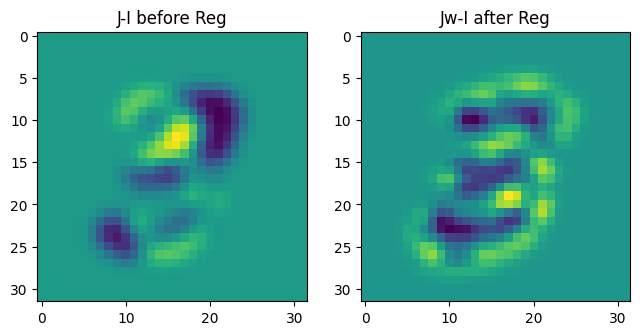

In [5]:
Jw, xyd, vs = network(J_,xy_)

# xyd_r = network(I_,J_,xy_,torch.zeros(1).to(device),-1.0*torch.ones(1).to(device))

Jw = F.grid_sample(J_,xyd,padding_mode='reflection',align_corners=True)
# Iw = F.grid_sample(I_,xyd_r,padding_mode='reflection',align_corners=True)

%matplotlib inline
fig=plt.figure(figsize=(16,4))

fig.add_subplot(1,4,1)
plt.title("J-I before Reg")
plt.imshow((J_-I_).squeeze().cpu().data)

fig.add_subplot(1,4,2)
plt.imshow((Jw-I_).squeeze().cpu().data)
plt.title("Jw-I after Reg")

# fig.add_subplot(1,4,3)
# plt.title("I-J before Reg")
# plt.imshow((I_-J_).squeeze().cpu().data)

# fig.add_subplot(1,4,4)
# plt.imshow((Iw-J_).squeeze().cpu().data)
# plt.title("Iw-J after Reg")

plt.show()

### Do not edit the following cell

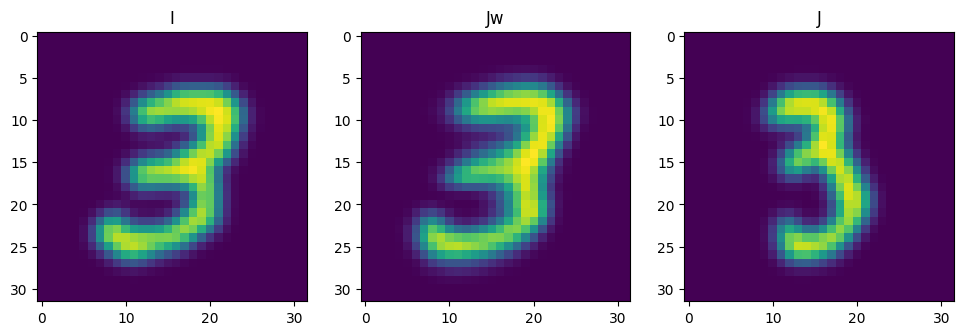

Max Difference Between Jw and I: 0.2032860368490219
Mean, STD of the |Jw - I| 0.024224884808063507 0.04229510575532913


In [6]:
# diff1 = (Iw - J_).abs()
diff2 = (Jw - I_).abs()

%matplotlib inline
fig=plt.figure(figsize=(16,4))

fig.add_subplot(1,4,1)
plt.title("I")
plt.imshow(I_.squeeze().cpu().data)

fig.add_subplot(1,4,2)
plt.imshow(Jw.squeeze().cpu().data)
plt.title("Jw")

fig.add_subplot(1,4,3)
plt.title("J")
plt.imshow(J_.squeeze().cpu().data)

# fig.add_subplot(1,4,4)
# plt.imshow(Iw.squeeze().cpu().data)
# plt.title("Iw")

plt.show()
print('Max Difference Between Jw and I:', (Jw - I_).max().item())
# print('Max Difference Between Iw and J:', (Iw - J_).max().item())
print('Mean, STD of the |Jw - I|',diff2.mean().item(), diff2.std().item())
# print('Mean, STD of the |Iw - J|', diff1.mean().item(), diff1.std().item())

### Do not edit the following cell

Text(0.5, 1.0, 'Forward')

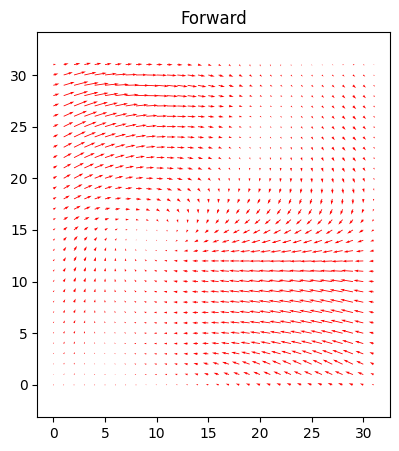

In [7]:
%matplotlib inline
df=1

%matplotlib inline

fig=plt.figure(figsize=(10,5))
d_ = (xyd - xy_).squeeze()
#fig=plt.figure(figsize=(5,5))
fig.add_subplot(1,2,1)
plt.quiver(d_.cpu().data[::df,::df,0], d_.cpu().data[::df,::df,1],color='r')
plt.axis('equal')
plt.title("Forward")

# d__ = (xyd_r - xy_).squeeze()
# #fig=plt.figure(figsize=(5,5))
# fig.add_subplot(1,2,2)
# plt.quiver(d__.cpu().data[::df,::df,0], d__.cpu().data[::df,::df,1],color='r')
# plt.axis('equal')
# plt.title("Reverse")
# plt.show()

### Do not edit the following cell

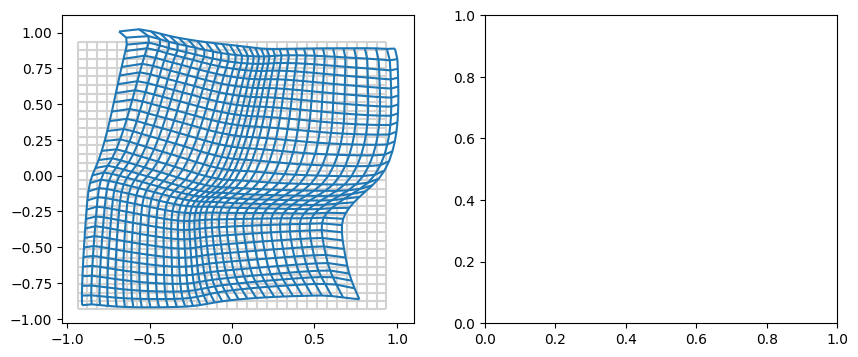

In [8]:
def plot_grid(x,y, ax=None, **kwargs):
    ax = ax or plt.gca()
    segs1 = np.stack((x,y), axis=2)
    segs2 = segs1.transpose(1,0,2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()

down_factor = 1
h_resize = int(down_factor*h_)
w_resize = int(down_factor*w_)

grid_x = resize(xy_.cpu()[:,1:-1,1:-1,0].squeeze().numpy(),(h_resize,w_resize))
grid_y = resize(xy_.cpu()[:,1:-1,1:-1,1].squeeze().numpy(),(h_resize,w_resize))
distx = resize(xyd.cpu()[:,1:-1,1:-1,0].squeeze().detach().numpy(),(h_resize,w_resize))
disty = resize(xyd.cpu()[:,1:-1,1:-1,1].squeeze().detach().numpy(),(h_resize,w_resize))
# distx_ = resize(xyd_r.cpu()[:,:,:,0].squeeze().detach().numpy(),(h_resize,w_resize))
# disty_ = resize(xyd_r.cpu()[:,:,:,1].squeeze().detach().numpy(),(h_resize,w_resize))

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10, 4))
plot_grid(grid_x,grid_y, ax=ax1,  color="lightgrey")
plot_grid(distx, disty, ax=ax1, color="C0")

# plot_grid(grid_x,grid_y, ax=ax2,  color="lightgrey")
# plot_grid(distx_, disty_, ax=ax2, color="C0")
plt.show()

## Do not edit the following cell

In [12]:
dx_dx = distx[1:-1,1:-1]-distx[1:-1,0:-2]
dx_dy = distx[1:-1,1:-1]-distx[0:-2,1:-1]
dy_dx = disty[1:-1,1:-1]-disty[1:-1,0:-2]
dy_dy = disty[1:-1,1:-1]-disty[0:-2,1:-1]

det = (dx_dx*dy_dy-dx_dy*dy_dx)<0.0
print("Percentage of folding in forward deformation:",100.*np.sum(det)/(dx_dx.shape[0]*dx_dx.shape[1]))

# dxr_dx = distx_[1:-1,1:-1]-distx_[1:-1,0:-2]
# dxr_dy = distx_[1:-1,1:-1]-distx_[0:-2,1:-1]
# dyr_dx = disty_[1:-1,1:-1]-disty_[1:-1,0:-2]
# dyr_dy = disty_[1:-1,1:-1]-disty_[0:-2,1:-1]

# detr = (dxr_dx*dyr_dy-dxr_dy*dyr_dx)<0.0
# print("Percentage of folding in backward deformation:",100.*np.sum(detr)/(dxr_dx.shape[0]*dxr_dx.shape[1]))

Percentage of folding in forward deformation: 0.0
